# Training Model

In [ ]:
# Xử lý dữ liệu
import pandas as pd
import numpy as np

# Vẽ biểu đồ
import matplotlib.pyplot as plt

# Tiền xử lý và chia tập
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Mô hình học máy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Đánh giá mô hình
from sklearn.metrics import (
    f1_score,
    classification_report,
    balanced_accuracy_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Xử lý mất cân bằng dữ liệu
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gán tên cột đúng
column_names = [
    'CHRONIC_DISEASE', 'ANXIETY', 'AGE', 'CHEST_PAIN', 'LUNG_CANCER',
    'PEER_PRESSURE', 'COUGHING', 'YELLOW_FINGERS', 'BREATHING_ISSUE',
    'ALCOHOL_CONSUMING', 'SMOKING', 'GENDER'
]

# Đọc dữ liệu và gán tên cột
data = pd.read_csv('dataset_normalized_fin.csv')
data.columns = column_names

# Tách nhãn và đặc trưng
y = data['LUNG_CANCER']
X = data.drop(columns=['LUNG_CANCER'])

print(y.value_counts())

# Chia dữ liệu train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LUNG_CANCER
1    15273
0     6481
Name: count, dtype: int64


## KNN

Fitting 5 folds for each of 76 candidates, totalling 380 fits

Best parameters: {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best F1-score (label=1): 0.8194

Các thuộc tính có độ quan trọng âm:
Empty DataFrame
Columns: [Feature, Importance Mean, Importance Std]
Index: []


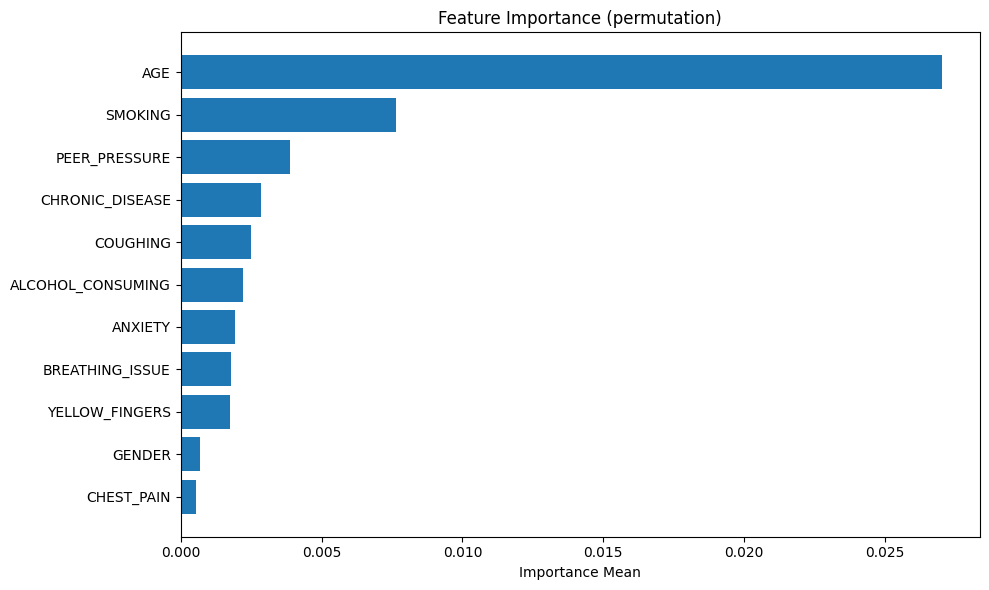


=== Classification Report trên tập validation ===
              precision    recall  f1-score   support

           0     0.6238    0.1497    0.2414      1296
           1     0.7272    0.9617    0.8282      3055

    accuracy                         0.7198      4351
   macro avg     0.6755    0.5557    0.5348      4351
weighted avg     0.6964    0.7198    0.6534      4351

Final F1-score (label=1): 0.8282


In [ ]:
# Định nghĩa các tham số cho GridSearchCV
param_grid = {
    'n_neighbors': range(1, 20),
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

# Khởi tạo mô hình KNN
knn = KNeighborsClassifier()

# Ưu tiên F1-score cho nhãn 1
f1_cancer = make_scorer(f1_score, pos_label=1)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=f1_cancer,
    cv=5,
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In ra kết quả tối ưu
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best F1-score (label=1): {grid_search.best_score_:.4f}")

# Mô hình tốt nhất
best_model = grid_search.best_estimator_

# Tính độ quan trọng của đặc trưng bằng permutation importance
perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=100, random_state=42)

# Tạo DataFrame độ quan trọng
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

# In các thuộc tính có độ quan trọng âm (không hữu ích)
print("\nCác thuộc tính có độ quan trọng âm:")
print(importance_df[importance_df['Importance Mean'] < 0])

# Vẽ biểu đồ độ quan trọng
importance_df.sort_values(by='Importance Mean', ascending=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'])
plt.xlabel('Importance Mean')
plt.title('Feature Importance (permutation)')
plt.tight_layout()
plt.show()

# Lọc các đặc trưng quan trọng dương
important_features = importance_df[importance_df['Importance Mean'] > 0]['Feature']

# Gộp lại tập train + validation và chọn đặc trưng quan trọng
X_train_val = pd.concat([X_train, X_val], axis=0)[important_features]
y_train_val = pd.concat([y_train, y_val], axis=0)

# Huấn luyện lại mô hình tốt nhất với các đặc trưng quan trọng
best_model.fit(X_train_val, y_train_val)

# Đánh giá trên tập validation ban đầu
y_val_pred = best_model.predict(X_val[important_features])
print("\n=== Classification Report trên tập validation ===")
print(classification_report(y_val, y_val_pred, digits=4))

# In F1-score cuối cùng cho nhãn 1
final_f1 = f1_score(y_val, y_val_pred, pos_label=1)
print(f"Final F1-score (label=1): {final_f1:.4f}")


## Logistics Regression

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



Best parameters: {'C': np.float64(0.01), 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Best F1-score (label=1): 0.6403
              Feature  Importance Mean  Importance Std
0     CHRONIC_DISEASE         0.000000        0.000000
1             ANXIETY         0.000000        0.000000
2                 AGE         0.019400        0.006527
3          CHEST_PAIN         0.000000        0.000000
4       PEER_PRESSURE         0.000000        0.000000
5            COUGHING         0.000000        0.000000
6      YELLOW_FINGERS         0.000000        0.000000
7     BREATHING_ISSUE         0.000000        0.000000
8   ALCOHOL_CONSUMING         0.003951        0.003112
9             SMOKING         0.001085        0.003695
10             GENDER         0.000000        0.000000

Các thuộc tính có độ quan trọng âm:
Empty DataFrame
Columns: [Feature, Importance Mean, Importance Std]
Index: []


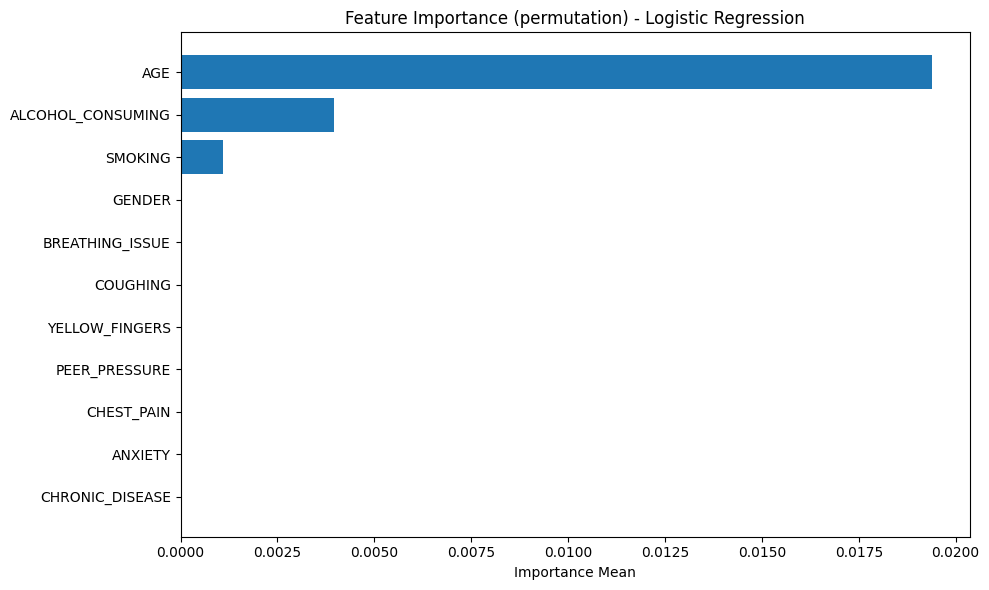

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



=== Classification Report trên tập validation ===
              precision    recall  f1-score   support

           0     0.3328    0.5123    0.4035      1296
           1     0.7317    0.5643    0.6372      3055

    accuracy                         0.5488      4351
   macro avg     0.5323    0.5383    0.5204      4351
weighted avg     0.6129    0.5488    0.5676      4351

Final F1-score (label=1): 0.6372


In [ ]:
# 1. Tạo lưới siêu tham số
param_grid = {
    'C': np.round(np.arange(0.01, 2.01, 0.02), 2),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],  # saga hỗ trợ cả l1, l2, elasticnet
    'l1_ratio': [0.5]     # dùng cho elasticnet (bắt buộc khi chọn elasticnet)
}

# 2. Khởi tạo Logistic Regression
logreg = LogisticRegression(max_iter=10000, class_weight='balanced')

# 3. F1-score cho nhãn 1 (ung thư)
f1_cancer = make_scorer(f1_score, pos_label=1)

# 4. GridSearchCV để chọn tham số tối ưu
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring=f1_cancer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 5. Huấn luyện trên tập train
grid_search.fit(X_train, y_train)

# 6. Thông báo kết quả tốt nhất
print("\nBest parameters:", grid_search.best_params_)
print(f"Best F1-score (label=1): {grid_search.best_score_:.4f}")

# 7. Mô hình tốt nhất
best_model = grid_search.best_estimator_

# 8. Tính permutation importance trên tập validation
perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=100, random_state=42)

# 9. Biến DataFrame chứa độ quan trọng
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})
print(importance_df)

# 10. In các đặc trưng không quan trọng
print("\nCác thuộc tính có độ quan trọng âm:")
print(importance_df[importance_df['Importance Mean'] < 0])

# 11. Vẽ biểu đồ độ quan trọng
importance_df.sort_values(by='Importance Mean', ascending=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'])
plt.xlabel('Importance Mean')
plt.title('Feature Importance (permutation) - Logistic Regression')
plt.tight_layout()
plt.show()

# 12. Chọn các đặc trưng quan trọng
important_features = importance_df[importance_df['Importance Mean'] > 0]['Feature']

# 13. Gộp lại tập train + val
X_train_val = pd.concat([X_train, X_val], axis=0)[important_features]
y_train_val = pd.concat([y_train, y_val], axis=0)

# 14. Huấn luyện lại trên toàn bộ tập train+val với đặc trưng tốt
best_model.fit(X_train_val, y_train_val)

# 15. Dự đoán lại trên tập validation cũ (để so sánh)
y_val_pred = best_model.predict(X_val[important_features])
print("\n=== Classification Report trên tập validation ===")
print(classification_report(y_val, y_val_pred, digits=4))

# 16. In F1-score cuối cùng
final_f1 = f1_score(y_val, y_val_pred, pos_label=1)
print(f"Final F1-score (label=1): {final_f1:.4f}")

## Random Forest

Fitting 5 folds for each of 486 candidates, totalling 2430 fits

Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best F1-score (label=1): 0.7759

Các thuộc tính có độ quan trọng âm:
    Feature  Importance Mean  Importance Std
1   ANXIETY        -0.001002        0.002187
10   GENDER        -0.000715        0.001814


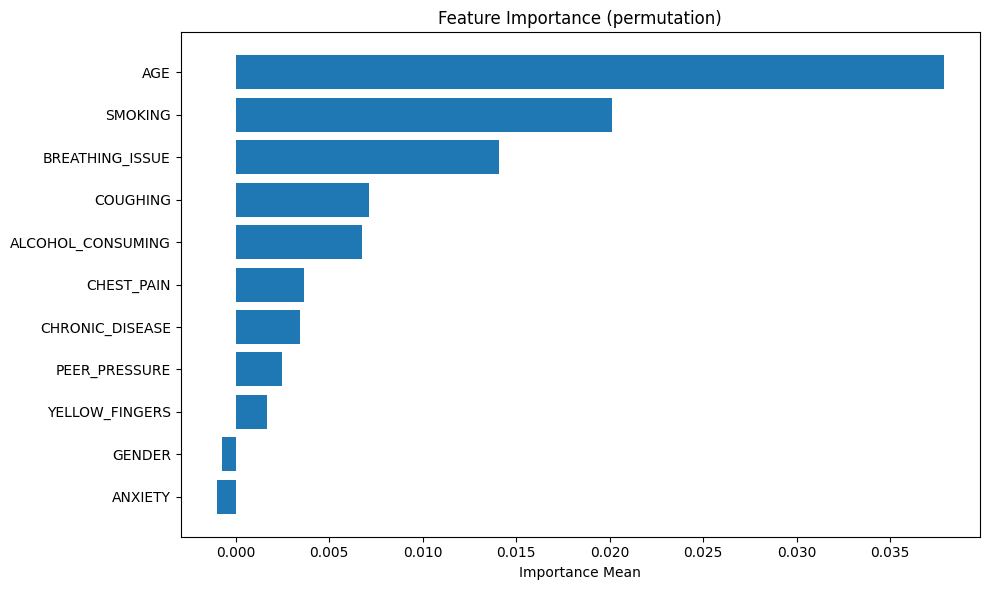


=== Classification Report trên tập validation ===
              precision    recall  f1-score   support

           0     0.5126    0.4066    0.4535      1296
           1     0.7686    0.8360    0.8009      3055

    accuracy                         0.7081      4351
   macro avg     0.6406    0.6213    0.6272      4351
weighted avg     0.6923    0.7081    0.6974      4351

Final F1-score (label=1): 0.8009


In [ ]:
# Định nghĩa các tham số cho GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [9, 10, 11],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Khởi tạo mô hình Random Forest
rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', random_state=42)

# Ưu tiên F1-score cho nhãn 1
f1_cancer = make_scorer(f1_score, pos_label=1)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_cancer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In ra kết quả tối ưu
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best F1-score (label=1): {grid_search.best_score_:.4f}")

# Mô hình tốt nhất
best_model = grid_search.best_estimator_

# Tính độ quan trọng của đặc trưng bằng permutation importance
perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=100, random_state=42)

# Tạo DataFrame độ quan trọng
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

# In các thuộc tính có độ quan trọng âm (không hữu ích)
print("\nCác thuộc tính có độ quan trọng âm:")
print(importance_df[importance_df['Importance Mean'] < 0])

# Vẽ biểu đồ độ quan trọng
importance_df.sort_values(by='Importance Mean', ascending=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'])
plt.xlabel('Importance Mean')
plt.title('Feature Importance (permutation)')
plt.tight_layout()
plt.show()

# Lọc các đặc trưng quan trọng dương
important_features = importance_df[importance_df['Importance Mean'] > 0]['Feature']

# Gộp lại tập train + validation và chọn đặc trưng quan trọng
X_train_val = pd.concat([X_train, X_val], axis=0)[important_features]
y_train_val = pd.concat([y_train, y_val], axis=0)

# Huấn luyện lại mô hình tốt nhất với các đặc trưng quan trọng
best_model.fit(X_train_val, y_train_val)

# Đánh giá lại trên tập validation ban đầu
y_val_pred = best_model.predict(X_val[important_features])
print("\n=== Classification Report trên tập validation ===")
print(classification_report(y_val, y_val_pred, digits=4))

# In F1-score cuối cùng cho nhãn 1
final_f1 = f1_score(y_val, y_val_pred, pos_label=1)
print(f"Final F1-score (label=1): {final_f1:.4f}")


## Decision Tree


Best F1-score: 0.8153
Best Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'min_impurity_decrease': np.float64(2e-06)}
              Feature  Importance Mean  Importance Std
0     CHRONIC_DISEASE         0.000000         0.00000
1             ANXIETY         0.000000         0.00000
2                 AGE         0.037941         0.00436
3          CHEST_PAIN         0.000000         0.00000
4       PEER_PRESSURE         0.000000         0.00000
5            COUGHING         0.000000         0.00000
6      YELLOW_FINGERS         0.000000         0.00000
7     BREATHING_ISSUE         0.000000         0.00000
8   ALCOHOL_CONSUMING         0.000000         0.00000
9             SMOKING         0.000000         0.00000
10             GENDER         0.000000         0.00000

Các đặc trưng có độ quan trọng âm:
Empty DataFrame
Columns: [Feature, Importance Mean, Importance Std]
Index: []


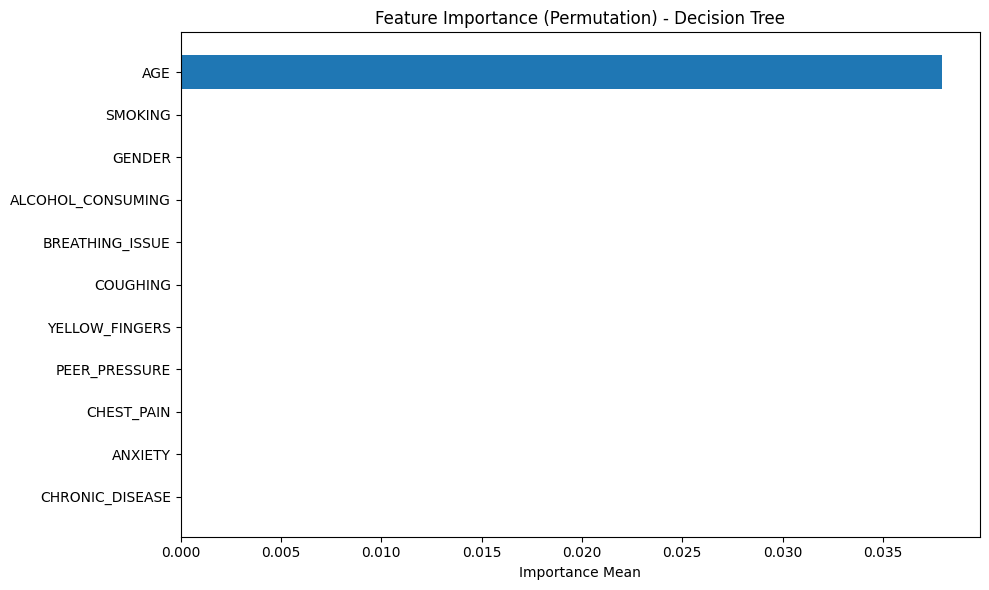


=== Classification Report trên tập validation ===
              precision    recall  f1-score   support

           0     0.5037    0.1574    0.2399      1296
           1     0.7233    0.9342    0.8153      3055

    accuracy                         0.7028      4351
   macro avg     0.6135    0.5458    0.5276      4351
weighted avg     0.6579    0.7028    0.6439      4351

Final F1-score (label=1): 0.8153


In [ ]:
# Định nghĩa các tham số cho GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [9, 10, 11],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Khởi tạo mô hình Random Forest
rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', random_state=42)

# Ưu tiên F1-score cho nhãn 1
f1_cancer = make_scorer(f1_score, pos_label=1)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_cancer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In ra kết quả tối ưu
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best F1-score (label=1): {grid_search.best_score_:.4f}")

# Mô hình tốt nhất
best_model = grid_search.best_estimator_

# Tính độ quan trọng của đặc trưng bằng permutation importance
perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=100, random_state=42)

# Tạo DataFrame độ quan trọng
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

# In các thuộc tính có độ quan trọng âm (không hữu ích)
print("\nCác thuộc tính có độ quan trọng âm:")
print(importance_df[importance_df['Importance Mean'] < 0])

# Vẽ biểu đồ độ quan trọng
importance_df.sort_values(by='Importance Mean', ascending=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'])
plt.xlabel('Importance Mean')
plt.title('Feature Importance (permutation)')
plt.tight_layout()
plt.show()

# Lọc các đặc trưng quan trọng dương
important_features = importance_df[importance_df['Importance Mean'] > 0]['Feature']

# Gộp lại tập train + validation và chọn đặc trưng quan trọng
X_train_val = pd.concat([X_train, X_val], axis=0)[important_features]
y_train_val = pd.concat([y_train, y_val], axis=0)

# Huấn luyện lại mô hình tốt nhất với các đặc trưng quan trọng
best_model.fit(X_train_val, y_train_val)

# Đánh giá lại trên tập validation ban đầu
y_val_pred = best_model.predict(X_val[important_features])
print("\n=== Classification Report trên tập validation ===")
print(classification_report(y_val, y_val_pred, digits=4))

# In F1-score cuối cùng cho nhãn 1
final_f1 = f1_score(y_val, y_val_pred, pos_label=1)
print(f"Final F1-score (label=1): {final_f1:.4f}")

## Using Combined Strategy


===== Testing KNN with Combined Resampling Strategy =====
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params: {'clf__n_neighbors': 19, 'clf__p': 2, 'clf__weights': 'uniform'}
Balanced Accuracy: 0.5390
F1-Score (Class 0): 0.3491
F1-Score (Class 1): 0.7295

Full Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.34      0.35      1296
           1       0.73      0.73      0.73      3055

    accuracy                           0.62      4351
   macro avg       0.54      0.54      0.54      4351
weighted avg       0.61      0.62      0.62      4351


===== Testing RandomForest with Combined Resampling Strategy =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Balanced Accuracy: 0.5571
F1-Score (Class 0): 0.3212
F1-Score (Class 1): 0.7901

Full Classification Report:
              precision    recall  f

<Figure size 800x600 with 0 Axes>

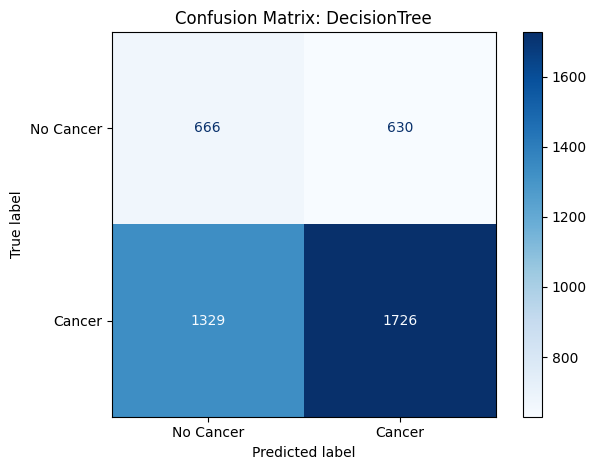

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# ==== Load Data ====
column_names = [
    'CHRONIC_DISEASE', 'ANXIETY', 'AGE', 'CHEST_PAIN', 'LUNG_CANCER',
    'PEER_PRESSURE', 'COUGHING', 'YELLOW_FINGERS', 'BREATHING_ISSUE',
    'ALCOHOL_CONSUMING', 'SMOKING', 'GENDER'
]

data = pd.read_csv('dataset_normalized_fin.csv')
data.columns = column_names

X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== Combined Strategy ====
combined_strategy = [
    ('over', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42))
]

# ==== Models and Parameters ====
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
            'clf__splitter': ['best', 'random'],
            'clf__max_depth': np.arange(1, 39),
            'clf__min_impurity_decrease': np.arange(start=0.000002, stop=0.00001, step=0.000002)
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    }
}

results = []

# ==== Loop over Models ====
for model_name, config in models.items():
    print(f"\n===== Testing {model_name} with Combined Resampling Strategy =====")

    steps = combined_strategy + [
        ('scaler', StandardScaler()),
        ('clf', config['model'])
    ]
    pipeline = ImbPipeline(steps)

    scorer = make_scorer(balanced_accuracy_score)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        scoring=scorer,
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    f1_class0 = report['0']['f1-score']
    f1_class1 = report['1']['f1-score']
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Balanced Accuracy': balanced_acc,
        'F1-Score (Class 0)': f1_class0,
        'F1-Score (Class 1)': f1_class1,
        'Full Report': classification_report(y_test, y_pred)
    })

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1-Score (Class 0): {f1_class0:.4f}")
    print(f"F1-Score (Class 1): {f1_class1:.4f}")
    print("\nFull Classification Report:")
    print(classification_report(y_test, y_pred))

# ==== Best Model Summary ====
best_result = max(results, key=lambda x: x['Balanced Accuracy'])
print("\n=== Best Model Summary ===")
print(f"Model: {best_result['Model']}")
print(f"Best Parameters: {best_result['Best Parameters']}")
print(f"Balanced Accuracy: {best_result['Balanced Accuracy']:.4f}")
print(f"F1-Score (Class 0): {best_result['F1-Score (Class 0)']:.4f}")
print(f"F1-Score (Class 1): {best_result['F1-Score (Class 1)']:.4f}")
print("\nFull Classification Report:")
print(best_result['Full Report'])

# ==== Confusion Matrix for Best Model ====
best_model = [r for r in results if r['Model'] == best_result['Model']][0]
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix: {best_result["Model"]}')
plt.tight_layout()
plt.show()


## SMOTE


===== Testing KNN with SMOTE-only Strategy =====
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'clf__n_neighbors': 17, 'clf__p': 2, 'clf__weights': 'uniform'}
Balanced Accuracy: 0.5158
F1-Score (Class 0): 0.3391
F1-Score (Class 1): 0.6891

Full Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.36      0.34      1296
           1       0.71      0.67      0.69      3055

    accuracy                           0.58      4351
   macro avg       0.51      0.52      0.51      4351
weighted avg       0.59      0.58      0.58      4351


===== Testing RandomForest with SMOTE-only Strategy =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Balanced Accuracy: 0.5419
F1-Score (Class 0): 0.3316
F1-Score (Class 1): 0.7533

Full Classification Report:
              precision    recall  f1-score   support


<Figure size 800x600 with 0 Axes>

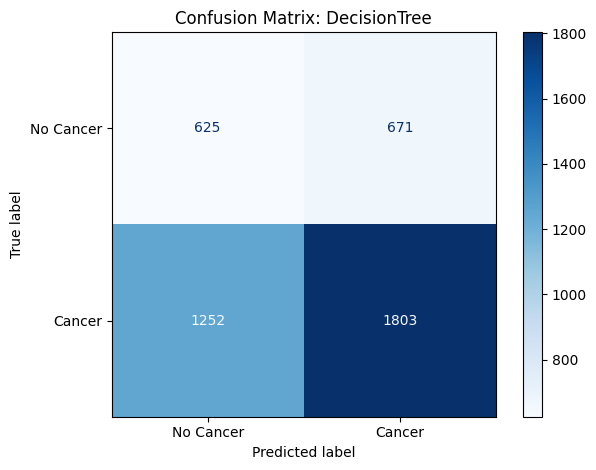

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ==== Load Data ====
column_names = [
    'CHRONIC_DISEASE', 'ANXIETY', 'AGE', 'CHEST_PAIN', 'LUNG_CANCER',
    'PEER_PRESSURE', 'COUGHING', 'YELLOW_FINGERS', 'BREATHING_ISSUE',
    'ALCOHOL_CONSUMING', 'SMOKING', 'GENDER'
]

data = pd.read_csv('dataset_normalized_fin.csv')
data.columns = column_names

X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ====  SMOTE  ====
smote_only = [('over', SMOTE(sampling_strategy=0.9, random_state=42))]

# ==== Models and Parameters ====
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
            'clf__splitter': ['best', 'random'],
            'clf__max_depth': np.arange(1, 39),
            'clf__min_impurity_decrease': np.arange(start=0.000002, stop=0.00001, step=0.000002)
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    }
}

results = []

# ==== Loop over Models ====
for model_name, config in models.items():
    print(f"\n===== Testing {model_name} with SMOTE-only Strategy =====")

    steps = smote_only + [
        ('scaler', StandardScaler()),
        ('clf', config['model'])
    ]
    pipeline = ImbPipeline(steps)

    scorer = make_scorer(balanced_accuracy_score)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        scoring=scorer,
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    f1_class0 = report['0']['f1-score']
    f1_class1 = report['1']['f1-score']
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Balanced Accuracy': balanced_acc,
        'F1-Score (Class 0)': f1_class0,
        'F1-Score (Class 1)': f1_class1,
        'Full Report': classification_report(y_test, y_pred)
    })

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1-Score (Class 0): {f1_class0:.4f}")
    print(f"F1-Score (Class 1): {f1_class1:.4f}")
    print("\nFull Classification Report:")
    print(classification_report(y_test, y_pred))

# ==== Best Model Summary ====
best_result = max(results, key=lambda x: x['Balanced Accuracy'])
print("\n=== Best Model Summary ===")
print(f"Model: {best_result['Model']}")
print(f"Best Parameters: {best_result['Best Parameters']}")
print(f"Balanced Accuracy: {best_result['Balanced Accuracy']:.4f}")
print(f"F1-Score (Class 0): {best_result['F1-Score (Class 0)']:.4f}")
print(f"F1-Score (Class 1): {best_result['F1-Score (Class 1)']:.4f}")
print("\nFull Classification Report:")
print(best_result['Full Report'])

# ==== Confusion Matrix for Best Model ====
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix: {best_result["Model"]}')
plt.tight_layout()
plt.show()



===== Testing KNN with SMOTE-ENN Strategy =====
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'uniform'}
Balanced Accuracy: 0.5374
F1-Score (Class 0): 0.3731
F1-Score (Class 1): 0.6936

Full Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.41      0.37      1296
           1       0.73      0.66      0.69      3055

    accuracy                           0.59      4351
   macro avg       0.53      0.54      0.53      4351
weighted avg       0.61      0.59      0.60      4351


===== Testing RandomForest with SMOTE-ENN Strategy =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Balanced Accuracy: 0.5508
F1-Score (Class 0): 0.3478
F1-Score (Class 1): 0.7560

Full Classification Report:
              precision    recall  f1-score   support

 

<Figure size 800x600 with 0 Axes>

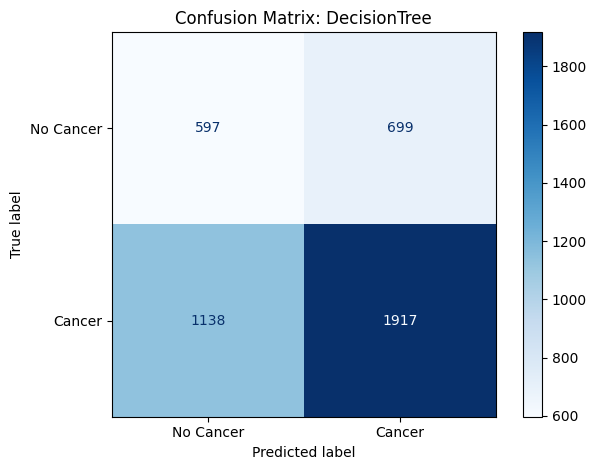

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN, SMOTETomek  # Import SMOTEENN and SMOTETomek

# ==== Load Data ====
column_names = [
    'CHRONIC_DISEASE', 'ANXIETY', 'AGE', 'CHEST_PAIN', 'LUNG_CANCER',
    'PEER_PRESSURE', 'COUGHING', 'YELLOW_FINGERS', 'BREATHING_ISSUE',
    'ALCOHOL_CONSUMING', 'SMOKING', 'GENDER'
]

data = pd.read_csv('dataset_normalized_fin.csv')
data.columns = column_names

X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== Choose SMOTE + ENN or SMOTE + Tomek ====

# Option 1: Using SMOTE + ENN
smote_enn = [('over', SMOTEENN(sampling_strategy=0.9, random_state=42))]

# Option 2: Using SMOTE + Tomek
# smote_tomek = [('over', SMOTETomek(sampling_strategy=0.9, random_state=42))]

# ==== Models and Parameters ====
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
            'clf__splitter': ['best', 'random'],
            'clf__max_depth': np.arange(1, 39),
            'clf__min_impurity_decrease': np.arange(start=0.000002, stop=0.00001, step=0.000002)
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced'),
        'param_grid': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    }
}

results = []

# ==== Loop over Models ====
for model_name, config in models.items():
    print(f"\n===== Testing {model_name} with SMOTE-ENN Strategy =====")

    steps = smote_enn + [  # Replace smote_enn with smote_tomek for the other strategy
        ('scaler', StandardScaler()),
        ('clf', config['model'])
    ]
    pipeline = ImbPipeline(steps)

    scorer = make_scorer(balanced_accuracy_score)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        scoring=scorer,
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    f1_class0 = report['0']['f1-score']
    f1_class1 = report['1']['f1-score']
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Balanced Accuracy': balanced_acc,
        'F1-Score (Class 0)': f1_class0,
        'F1-Score (Class 1)': f1_class1,
        'Full Report': classification_report(y_test, y_pred)
    })

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1-Score (Class 0): {f1_class0:.4f}")
    print(f"F1-Score (Class 1): {f1_class1:.4f}")
    print("\nFull Classification Report:")
    print(classification_report(y_test, y_pred))

# ==== Best Model Summary ====
best_result = max(results, key=lambda x: x['Balanced Accuracy'])
print("\n=== Best Model Summary ===")
print(f"Model: {best_result['Model']}")
print(f"Best Parameters: {best_result['Best Parameters']}")
print(f"Balanced Accuracy: {best_result['Balanced Accuracy']:.4f}")
print(f"F1-Score (Class 0): {best_result['F1-Score (Class 0)']:.4f}")
print(f"F1-Score (Class 1): {best_result['F1-Score (Class 1)']:.4f}")
print("\nFull Classification Report:")
print(best_result['Full Report'])

# ==== Confusion Matrix for Best Model ====
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix: {best_result["Model"]}')
plt.tight_layout()
plt.show()
